# Visualizing Fire Scars Through False Color
Author: Matteo Torres

Repository: https://github.com/matteo-torres/eds220-hwk4

## About
The purpose of this notebook is to visualize the fire scars created by the Thomas Fire in 2017 using false-color images from remote sensing techniques.

## Highlights
- Explore the `xarray.Dataset`
- Create a true color image (RGB)
- Create a false color image
- Visualize the Thomas fire of 2017 using a false color image

## About the data
The California Fire Perimeter and Prescribed Fire Database offers spatial data on historical wildfires and prescribed burns dating back to 1878. This database is maintained by several agencies, including CAL FIRE, the USDA Forest Service, and the National Park Service.

The Landsat Collection 2 Level-2 dataset includes atmospherically corrected surface reflectance and temperature image data. This dataset, collected from the Landsat 8 satellite, has been pre-processed to exclude data outside land areas. It also features a coarser spatial resolution and a simplified collection of bands: red, green, blue, near-infrared, and shortwave infrared.

## References
California Department of Forestry and Fire Protection. (n.d.). California fire perimeters (all) [Dataset]. Data.gov. https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436

Earth Resources Observation and Science (EROS) Center. (2020). Landsat 8-9 Operational Land Imager / Thermal Infrared Sensor Level-2, Collection 2 [dataset]. U.S. Geological Survey. https://doi.org/10.5066/P9OGBGM6

## Import libraries

In [1]:
import os
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

## Import data

In [2]:
# Import datasets from data directory
data_dir = os.path.join(os.getcwd(), "data")

# Read in landsat data
landsat = rioxr.open_rasterio(os.path.join(data_dir, "hwk4_landsat_data", "landsat8-2018-01-26-sb-simplified.nc"))

# Read in Thomas fire (2017) shapefile
thomas_fire = gpd.read_file(os.path.join(data_dir, "thomas_fire", "thomas_fire.shp"))

## Data exploration

In [3]:
# Look at the landsat raster
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

In [4]:
# Look at the dimensions
landsat.rio.shape

(731, 870)

In [5]:
# Look at the data types
landsat.dtypes

Frozen({'red': dtype('float64'), 'green': dtype('float64'), 'blue': dtype('float64'), 'nir08': dtype('float64'), 'swir22': dtype('float64')})

In [6]:
# Look at the coordinate reference system
landsat.rio.crs

CRS.from_epsg(32611)

### Summary
During the preliminary data exploration, I gathered information about the raster's dimensions, data types, and coordinate reference system. I observed that the Landsat data consists of three dimensions: band, x, and y. The band dimension has a length of one, while both the x and y dimensions have a length of five.

## Data wrangling

In [7]:
# Drop the band dimension
landsat = landsat.squeeze().drop_vars("band")

# Verify
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (x: 870, y: 731)
Coordinates:
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float64 5MB ...
    green        (y, x) float64 5MB ...
    blue         (y, x) float64 5MB ...
    nir08        (y, x) float64 5MB ...
    swir22       (y, x) float64 5MB ...

## True color image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


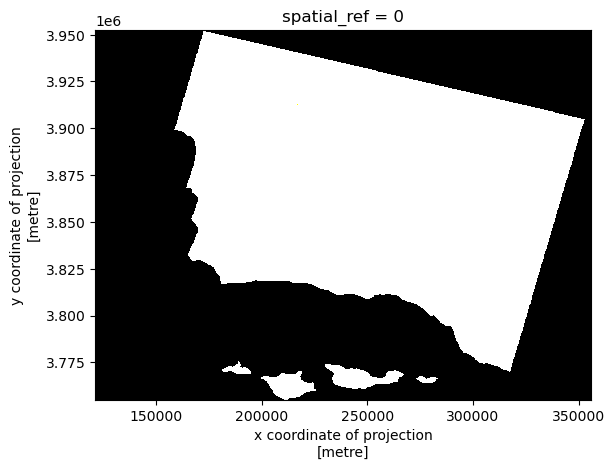

In [8]:
# Create an RGB image
landsat[["red", "green", "blue"]].to_array().plot.imshow()

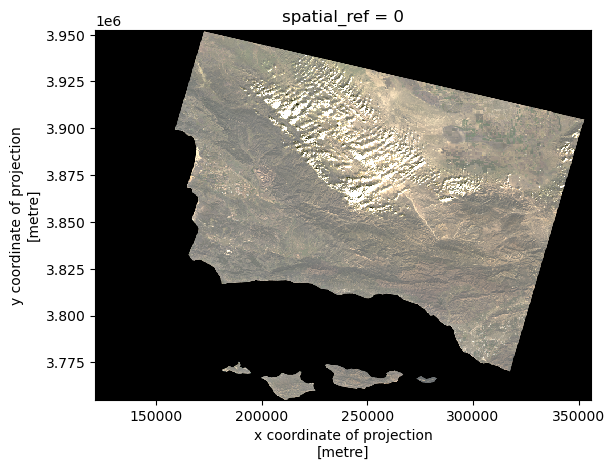

In [9]:
# Adjust the scale used for plotting the bands to get a true color image
landsat[["red", "green", "blue"]].to_array().plot.imshow(robust = True)

### Compare
In the first image, the RGB values are outliers, which causes the other values to be compressed when plotted. In the second image, using the command `robust=True` adjusts the scale to be more sensitive to these outliers, resulting in a more accurate true color image. 

## False color image

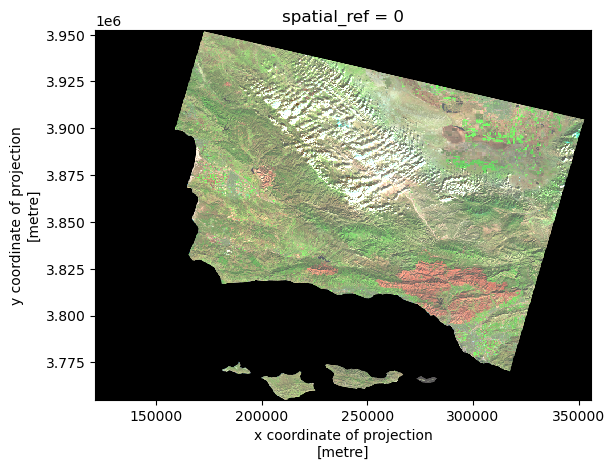

In [10]:
# Create a false color image
landsat[["swir22", "nir08", "red"]].to_array().plot.imshow(robust = True)

## Map

In [11]:
# Check for matching CRS
print("landsat CRS: ", landsat.rio.crs)
print("thomas_fire CRS: ", thomas_fire.crs)

landsat CRS:  EPSG:32611
thomas_fire CRS:  EPSG:3857


In [12]:
# Reproject Thomas fire CRS
thomas_fire = thomas_fire.to_crs(landsat.rio.crs)
print('Matched CRS?',  thomas_fire.crs == landsat.rio.crs)

Matched CRS? True


In [13]:
# Raster aspect ratio
aspect_ratio = landsat.rio.width/landsat.rio.height

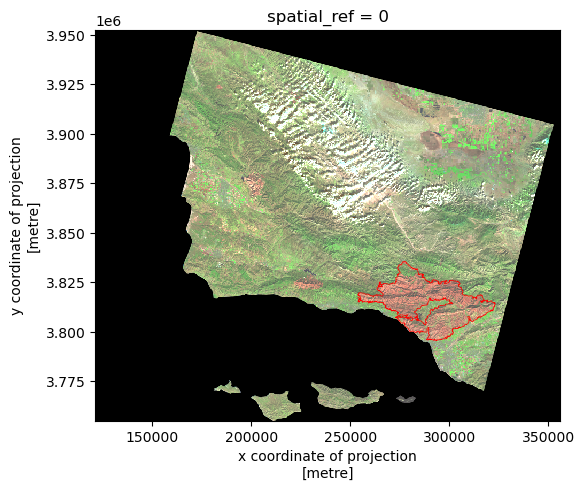

In [14]:
# Create a false color image map of the Thomas Fire (2017) perimeter
fig, ax = plt.subplots(figsize = (6, 6 * aspect_ratio))

landsat[["swir22", "nir08", "red"]].to_array().plot.imshow(robust = True, ax = ax)

thomas_fire.plot(ax = ax, 
                 facecolor = "none", 
                 edgecolor = "red", 
                 linewidth = 0.5)

plt.show()

In [15]:
# Clip raster to thomas fire boundaries
landsat_clip = landsat.rio.clip_box(*thomas_fire.total_bounds)

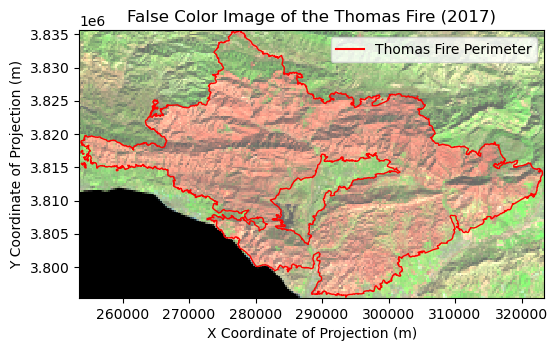

In [16]:
# Plot the clipped raster
fig, ax = plt.subplots(figsize = (6, 6 * aspect_ratio))

landsat_clip[["swir22", "nir08", "red"]].to_array().plot.imshow(robust = True)

thomas_fire.plot(ax = ax, 
                 facecolor = "none", 
                 edgecolor = "red", 
                 linewidth = 1)

# Set title
ax.set_title("False Color Image of the Thomas Fire (2017)")

# Update labels
ax.set_xlabel("X Coordinate of Projection (m)")
ax.set_ylabel("Y Coordinate of Projection (m)")

# Manually create a legend
legend_elements = [Line2D([0], [0], 
                          color = "red", 
                          lw = 1.5, 
                          label = "Thomas Fire Perimeter")]

ax.legend(handles = legend_elements)

plt.show()

### Description
The map illustrates the effects of the Thomas Fire, which occurred in 2017. The false color image (using shortwave infrared, near-infrared, and red wavelengths) highlights areas of the burn scar on vegetation in red. In this imagery, green is typically used to assess vegetation health and density; the brighter or more vivid the green, the healthier and denser the vegetation appears.